In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset Link:** https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy/input?select=Sarcasm_Headlines_Dataset.json

In [ ]:
data = pd.read_json("/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json", lines=True)
with open("/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json", "r") as file:
    for line in file:
        json_object = json.loads(line)
        # Process or inspect json_object
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# **Data Preprocessing**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove website links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove extra spaces
    text = ' '.join(text.split())

    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    return ' '.join(filtered_text)


# Apply the preprocessing function to the 'headline' column
data['headline'] = data['headline'].apply(preprocess_text)


In [ ]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues secret black c...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,roseanne revival catches thorny political mood...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting fear sons web series closest thin...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner wants wife listen come alternative deb...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday magical...,0


# **Visualization of Label Distribution**
* **0.0 - Not Sarcastic**
* **1.0 - Sarcastic**

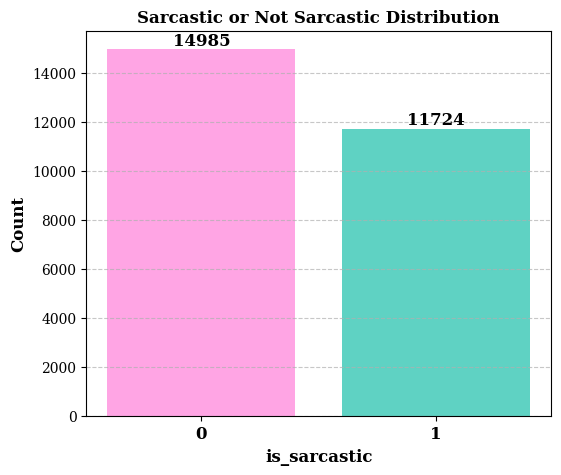

In [ ]:
label_counts = data['is_sarcastic'].value_counts()

# Define custom colors for the bars ('Real' and 'Fake')
custom_colors = ['#ffa5e4', '#5fd2c3']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 5))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Sarcastic or Not Sarcastic Distribution', fontdict=font)
plt.xlabel('is_sarcastic', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Headline Length Distribution**

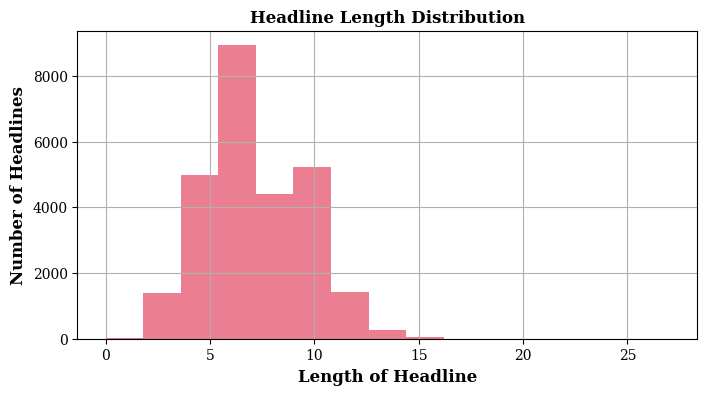

In [ ]:
# Visualize headline length distribution
headline_lengths = data['headline'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
# Define custom colors for the bars
custom_colors = ['#e34861']
plt.figure(figsize=(8, 4))
plt.hist(headline_lengths, bins=15, color=custom_colors, alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Headline Length Distribution',fontdict=font)
plt.xlabel('Length of Headline',fontdict=font)
plt.ylabel('Number of Headlines',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
plt.grid(True)
plt.show()

# **Checking if there is any null value in the dataset**

In [ ]:
# Check for null values in  'headline', and 'is_sarcastic' columns

null_headline = data['headline'].isnull().sum()
null_label = data['is_sarcastic'].isnull().sum()

print(f"Null values in 'headline': {null_headline}")
print(f"Null values in 'label': {null_label}")


Null values in 'headline': 0
Null values in 'label': 0


**70% - Train dataset, 20% - Test dataset, and 10% Validation dataset**

In [ ]:
# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, stratify=train_data['is_sarcastic'], random_state=42)

In [ ]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 19230
Length of test dataset: 5342
Length of validation dataset: 2137


# **Custom Dataset Class**

In [ ]:
class NewsSarcasmDetectionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=100):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['headline']
        label = self.data.iloc[idx]['is_sarcastic']

        inputs = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# **RoBERTa model and its tokenizer**

In [ ]:
from transformers import AutoTokenizer, RobertaModel, AdamW
# Initialize BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Custom dataset and dataloader**

In [ ]:
# Define custom datasets
train_dataset = NewsSarcasmDetectionDataset(train_data, tokenizer)
val_dataset = NewsSarcasmDetectionDataset(val_data, tokenizer)
test_dataset = NewsSarcasmDetectionDataset(test_data, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Train Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0,   506, 10505,  4113,   662,  1047, 20125,   802,    74,  3013,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        

# **Test Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0,   354,   354, 36425,  8660,  2283,  1686,  1406,   239,   334,
          254,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        

# **Validation Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([    0,  1342,  1885,  5059, 29498, 12144, 25007,   780,   983,   618,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        

# **Train Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: 13 dead 6 injured blaze breaks french bar
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
Label: 0


# **Test Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: isis recruiter excited talking popular high schooler
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
Label: 1


# **Validation Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: entire blogosphere stunned bloggers special weekend post
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
Label: 1


# **Custom Classifier**

In [ ]:
# Define classifier
classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 2)
)

# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
classifier.to(device)


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
)

# **Optimizer and Loss Function**

In [ ]:
# Define optimizer and loss function
optimizer = AdamW(classifier.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# **Training the model**

In [ ]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output.to(device)

        classifier_outputs = classifier(pooled_output)
        loss = criterion(classifier_outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_train_loss}')

    # Validation
    classifier.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output.to(device)

            classifier_outputs = classifier(pooled_output)
            _, predicted = torch.max(classifier_outputs, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/3: 100%|██████████| 1202/1202 [01:46<00:00, 11.33it/s]


Average training loss: 0.6856797067278039


Validation: 100%|██████████| 134/134 [00:11<00:00, 11.55it/s]


Validation Accuracy: 0.5610669162377164


Epoch 2/3: 100%|██████████| 1202/1202 [01:43<00:00, 11.58it/s]


Average training loss: 0.6847444235187601


Validation: 100%|██████████| 134/134 [00:11<00:00, 11.62it/s]


Validation Accuracy: 0.5610669162377164


Epoch 3/3: 100%|██████████| 1202/1202 [01:44<00:00, 11.55it/s]


Average training loss: 0.683861733920959


Validation: 100%|██████████| 134/134 [00:11<00:00, 11.74it/s]

Validation Accuracy: 0.5610669162377164


# **Testing the model**

In [ ]:
# Testing
classifier.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc=f'Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output.to(device)

        classifier_outputs = classifier(pooled_output)
        _, predicted = torch.max(classifier_outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_log_loss = log_loss(test_labels, test_preds)
test_jaccard_score = jaccard_score(test_labels, test_preds)
test_roc_auc_score = roc_auc_score(test_labels, test_preds)

Testing: 100%|██████████| 334/334 [00:29<00:00, 11.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Printing the evaluation metric results**

In [ ]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Log loss: {test_log_loss}')
print(f'Test Jaccard Score: {test_jaccard_score}')
print(f'Test ROC AUC Score: {test_roc_auc_score}')

Test Accuracy: 0.5608386372145264
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0
Test Log loss: 15.828979942131943
Test Jaccard Score: 0.0
Test ROC AUC Score: 0.5


# **Classification Report**

In [ ]:
# Convert numeric predictions to label names ('Not Sarcastic' and 'Sarcastic')
predicted_labels = ['Not Sarcastic' if pred == 0 else 'Sarcastic' for pred in test_preds]
true_labels = ['Not Sarcastic' if label == 0 else 'Sarcastic' for label in test_labels]

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.56      1.00      0.72      2996
    Sarcastic       0.00      0.00      0.00      2346

     accuracy                           0.56      5342
    macro avg       0.28      0.50      0.36      5342
 weighted avg       0.31      0.56      0.40      5342



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Confusion Matrix of English Sarcasm Detection**

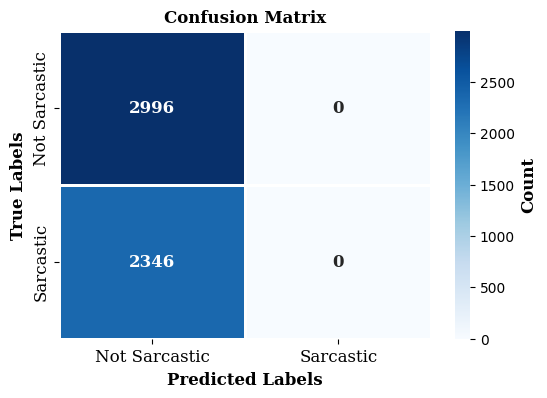

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='white',
                      xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Confusion Matrix', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)

plt.show()


# **Store predicted results to a csv file**

In [ ]:
# Combine the lists into a DataFrame
data = {'Headline': test_data['headline'],
        'True_Labels': test_data['is_sarcastic'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('roberta_predicted_results.csv', index=False)

# **save model, tokenizer, and classifier**

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/English_Sarcasm_Headlines/English_Sarcasm_Headlines_RoBERTa_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/English_Sarcasm_Headlines/English_Sarcasm_Headlines_RoBERTa_Tokenizer.json')

# Save the classifier separately using torch.save
torch.save(classifier.state_dict(), "/content/drive/MyDrive/English_Sarcasm_Headlines/RoBERTa_classifier.pth")



# **load model, tokenizer, and classifier**

In [ ]:
# load the model
model.from_pretrained('/content/drive/MyDrive/English_Sarcasm_Headlines/English_Sarcasm_Headlines_RoBERTa_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('/content/drive/MyDrive/English_Sarcasm_Headlines/English_Sarcasm_Headlines_RoBERTa_Tokenizer.json')

'''
This piece of code is needed before calling classifier.load_state_dict() to ensure that
the loaded state dictionary gets applied to the correct architecture.
'''
classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 2)
)
# load the classifier separately
classifier.load_state_dict(torch.load("/content/drive/MyDrive/English_Sarcasm_Headlines/RoBERTa_classifier.pth"))

<All keys matched successfully>